## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Дорожинский Владислав Игоревич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('../data/mnist', train=True, transform=transform)
test_dataset = MNIST('../data/mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

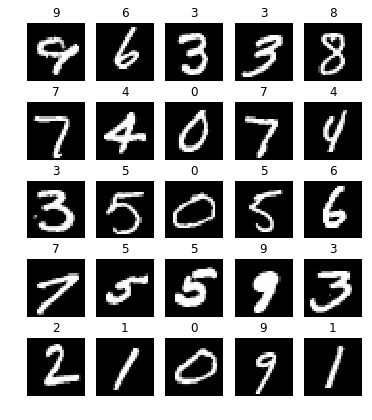

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [7]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().data[0]
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().data[0]
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [92]:
def new_linear_layer(input_size, output_size, mean=0.0, std=0.1, init=''):
    if init.lower() == 'he':
        mean = 0.0
        std = np.sqrt(2.0 / output_size)
    if init.lower() == 'xavier':
        mean = 0.0
        span = np.sqrt(6.0 / (output_size + input_size))
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    if init.lower() == 'xavier':
        layer.bias.data.zero_()
        layer.weight.data.uniform_(-span, span)
    else:
        init_layer(layer, mean, std)
    return layer

In [93]:
##### YOUR CODE HERE #####

def show(nonlinearity, init=''):
    layers = []
    layers.append(new_linear_layer(784, 500, mean=0, std=0.1, init=init))
    layers.append(nonlinearity())
    for i in range(10):
        layers.append(new_linear_layer(500, 500, mean=0, std=0.1, init=init))
        layers.append(nonlinearity())
    layers.append(new_linear_layer(500, 10, mean=0, std=0.1, init=init))
    layers.append(nn.LogSoftmax(1))
    network = nn.Sequential(*layers)
    
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [94]:
show(nn.ReLU)

forward 0.9950669407844543
forward 1.6760591268539429
forward 2.5081403255462646
forward 3.8450310230255127
forward 6.230496406555176
forward 9.886017799377441
forward 15.287677764892578
forward 22.412738800048828
forward 36.89181900024414
forward 62.312416076660156
forward 98.29739379882812
forward 145.981689453125
backward 0.004314916208386421
backward 0.0009548071539029479
backward 0.0015276405028998852
backward 0.0023837981279939413
backward 0.003891782136633992
backward 0.005988631397485733
backward 0.009438853710889816
backward 0.014552019536495209
backward 0.02329847402870655
backward 0.036315977573394775
backward 0.05625726655125618
backward 0.09041623771190643


In [95]:
show(nn.Tanh)

forward 0.9950669407844543
forward 0.8488942980766296
forward 0.7896489500999451
forward 0.7723920941352844
forward 0.7691866755485535
forward 0.7666532397270203
forward 0.7678782939910889
forward 0.766179084777832
forward 0.7639578580856323
forward 0.7601321339607239
forward 0.7634278535842896
forward 0.765082597732544
backward 0.003340358380228281
backward 0.0005638860166072845
backward 0.0006944226915948093
backward 0.000859239196870476
backward 0.0010406719520688057
backward 0.0012552861589938402
backward 0.0015152684645727277
backward 0.0018270952859893441
backward 0.0021923554595559835
backward 0.002651183633133769
backward 0.003056856105104089
backward 0.0030049034394323826


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [97]:
##### YOUR CODE HERE #####
show(nn.ReLU, 'he')

forward 0.9950669407844543
forward 1.0757540464401245
forward 1.0553849935531616
forward 1.0682504177093506
forward 1.0911638736724854
forward 1.0054106712341309
forward 1.0389870405197144
forward 1.0348564386367798
forward 1.0039856433868408
forward 1.0082757472991943
forward 1.0464041233062744
forward 1.0369694232940674
backward 0.00415291590616107
backward 0.004141937475651503
backward 0.0043582608923316
backward 0.00431899493560195
backward 0.00433756597340107
backward 0.004420331679284573
backward 0.004568016156554222
backward 0.004504817072302103
backward 0.0044454000890254974
backward 0.004372952971607447
backward 0.004402239806950092
backward 0.004501020535826683


In [98]:
show(nn.Tanh, 'xavier')

forward 0.9950669407844543
forward 0.6454376578330994
forward 0.49241694808006287
forward 0.4113815426826477
forward 0.36773648858070374
forward 0.3337433338165283
forward 0.3036060333251953
forward 0.27586829662323
forward 0.25868383049964905
forward 0.24367089569568634
forward 0.2325073778629303
forward 0.22138169407844543
backward 0.003005647100508213
backward 0.0005643159383907914
backward 0.000531063589733094
backward 0.0004957178607583046
backward 0.00046628198469989
backward 0.00043586333049461246
backward 0.00040741058182902634
backward 0.00035590087645687163
backward 0.0003140282351523638
backward 0.00026561308186501265
backward 0.0002076520468108356
backward 0.00014238303992897272


In [99]:
show(nn.Tanh, 'he')

forward 0.9950669407844543
forward 0.7641304135322571
forward 0.6532469987869263
forward 0.6036329865455627
forward 0.5766751766204834
forward 0.5674803256988525
forward 0.5570346117019653
forward 0.5531200766563416
forward 0.5514237880706787
forward 0.5506591200828552
forward 0.5534428358078003
forward 0.5540968179702759
backward 0.00393259059637785
backward 0.004017060622572899
backward 0.004245282616466284
backward 0.004479862283915281
backward 0.004806491080671549
backward 0.005094081163406372
backward 0.005423423834145069
backward 0.005605299025774002
backward 0.00569559819996357
backward 0.005671064835041761
backward 0.0052435933612287045
backward 0.004074698779731989


<i> 1.4 Сделайте выводы по первой части </i>

He init хорошо работает для ReLU.
Для Tanh выравнивается только дисперсия обратного распространения.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [16]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.cuda.FloatTensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = nn.Parameter(torch.cuda.FloatTensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x): 
        if not self.training: 
            return torch.mm(x, self.weight) + self.bias
        mask = torch.ones(self.weight.shape) * self.p
        mask = mask.cuda()
        mask = mask.bernoulli() / self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight * mask) + self.bias
        return output

Epoch 0... (Train/Test) NLL: 0.269/0.125	Accuracy: 0.922/0.962
Epoch 1... (Train/Test) NLL: 0.104/0.093	Accuracy: 0.968/0.970
Epoch 2... (Train/Test) NLL: 0.072/0.073	Accuracy: 0.978/0.977
Epoch 3... (Train/Test) NLL: 0.049/0.078	Accuracy: 0.984/0.975
Epoch 4... (Train/Test) NLL: 0.042/0.091	Accuracy: 0.986/0.973
Epoch 5... (Train/Test) NLL: 0.033/0.072	Accuracy: 0.989/0.978
Epoch 6... (Train/Test) NLL: 0.025/0.069	Accuracy: 0.992/0.980
Epoch 7... (Train/Test) NLL: 0.024/0.087	Accuracy: 0.992/0.978
Epoch 8... (Train/Test) NLL: 0.021/0.084	Accuracy: 0.993/0.977
Epoch 9... (Train/Test) NLL: 0.015/0.083	Accuracy: 0.995/0.980
Epoch 10... (Train/Test) NLL: 0.018/0.090	Accuracy: 0.994/0.978
Epoch 11... (Train/Test) NLL: 0.016/0.088	Accuracy: 0.994/0.981
Epoch 12... (Train/Test) NLL: 0.013/0.107	Accuracy: 0.996/0.977
Epoch 13... (Train/Test) NLL: 0.014/0.090	Accuracy: 0.995/0.980
Epoch 14... (Train/Test) NLL: 0.010/0.113	Accuracy: 0.996/0.977
Epoch 15... (Train/Test) NLL: 0.012/0.103	Accuracy

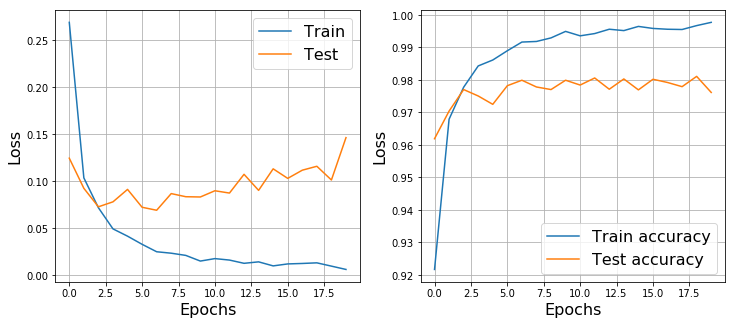

In [24]:
# No regularization
network = nn.Sequential(nn.Linear(784, 200),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))

train_loss_no, test_loss_no, train_acc_no, test_acc_no = train_utils.train(network,
                                                               train_loader,
                                                               test_loader,
                                                               20,
                                                               0.001,
                                                               ravel_init=True,
                                                               cuda=True)

Epoch 0... (Train/Test) NLL: 0.461/0.166	Accuracy: 0.857/0.950
Epoch 1... (Train/Test) NLL: 0.242/0.128	Accuracy: 0.928/0.962
Epoch 2... (Train/Test) NLL: 0.197/0.102	Accuracy: 0.942/0.969
Epoch 3... (Train/Test) NLL: 0.176/0.100	Accuracy: 0.948/0.970
Epoch 4... (Train/Test) NLL: 0.163/0.098	Accuracy: 0.951/0.970
Epoch 5... (Train/Test) NLL: 0.152/0.091	Accuracy: 0.954/0.972
Epoch 6... (Train/Test) NLL: 0.145/0.086	Accuracy: 0.956/0.973
Epoch 7... (Train/Test) NLL: 0.133/0.083	Accuracy: 0.959/0.975
Epoch 8... (Train/Test) NLL: 0.131/0.079	Accuracy: 0.960/0.977
Epoch 9... (Train/Test) NLL: 0.124/0.075	Accuracy: 0.962/0.977
Epoch 10... (Train/Test) NLL: 0.122/0.073	Accuracy: 0.963/0.979
Epoch 11... (Train/Test) NLL: 0.119/0.073	Accuracy: 0.964/0.978
Epoch 12... (Train/Test) NLL: 0.117/0.076	Accuracy: 0.964/0.978
Epoch 13... (Train/Test) NLL: 0.116/0.076	Accuracy: 0.965/0.979
Epoch 14... (Train/Test) NLL: 0.111/0.074	Accuracy: 0.966/0.980
Epoch 15... (Train/Test) NLL: 0.106/0.075	Accuracy

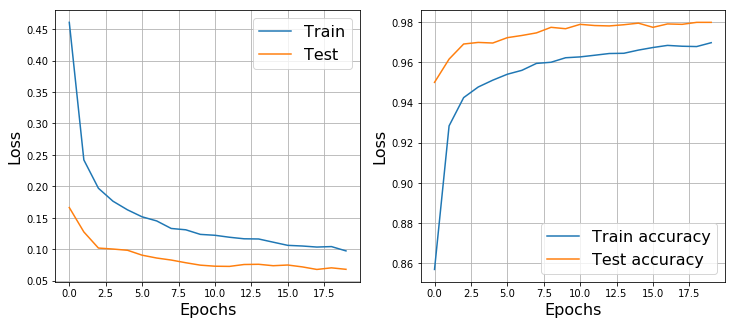

In [23]:
# DropOut
network = nn.Sequential(nn.Linear(784, 200),
                      nn.Dropout(0.5),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.Dropout(0.5),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))

train_loss_do, test_loss_do, train_acc_do, test_acc_do = train_utils.train(network,
                                                               train_loader,
                                                               test_loader,
                                                               20,
                                                               0.001,
                                                               ravel_init=True,
                                                               cuda=True)

Epoch 0... (Train/Test) NLL: 0.389/0.158	Accuracy: 0.883/0.952
Epoch 1... (Train/Test) NLL: 0.173/0.116	Accuracy: 0.948/0.964
Epoch 2... (Train/Test) NLL: 0.137/0.103	Accuracy: 0.958/0.969
Epoch 3... (Train/Test) NLL: 0.118/0.091	Accuracy: 0.963/0.972
Epoch 4... (Train/Test) NLL: 0.106/0.080	Accuracy: 0.966/0.974
Epoch 5... (Train/Test) NLL: 0.102/0.082	Accuracy: 0.967/0.974
Epoch 6... (Train/Test) NLL: 0.096/0.082	Accuracy: 0.969/0.975
Epoch 7... (Train/Test) NLL: 0.087/0.073	Accuracy: 0.972/0.976
Epoch 8... (Train/Test) NLL: 0.085/0.075	Accuracy: 0.973/0.976
Epoch 9... (Train/Test) NLL: 0.079/0.065	Accuracy: 0.975/0.980
Epoch 10... (Train/Test) NLL: 0.083/0.065	Accuracy: 0.973/0.979
Epoch 11... (Train/Test) NLL: 0.077/0.070	Accuracy: 0.976/0.978
Epoch 12... (Train/Test) NLL: 0.077/0.069	Accuracy: 0.975/0.979
Epoch 13... (Train/Test) NLL: 0.073/0.061	Accuracy: 0.975/0.981
Epoch 14... (Train/Test) NLL: 0.072/0.063	Accuracy: 0.977/0.981
Epoch 15... (Train/Test) NLL: 0.071/0.069	Accuracy

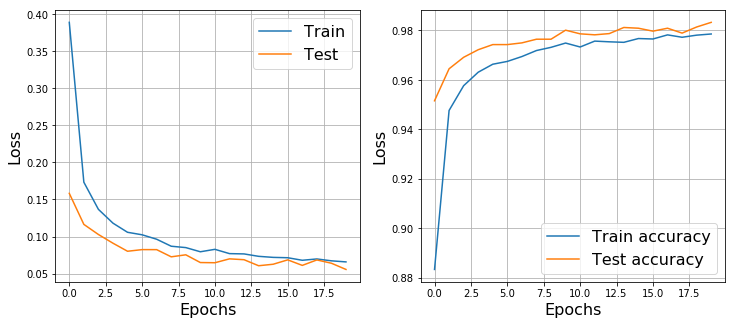

In [26]:
# DropConnect
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax(1))

train_loss_dc, test_loss_dc, train_acc_dc, test_acc_dc = train_utils.train(network,
                                                               train_loader,
                                                               test_loader,
                                                               20,
                                                               0.001,
                                                               ravel_init=True,
                                                               cuda=True)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

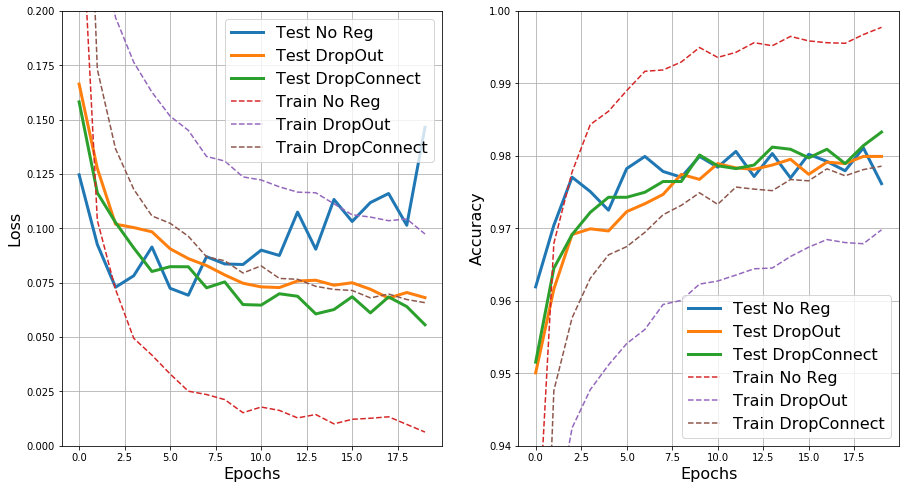

In [46]:
##### YOUR CODE HERE #####

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(test_loss_no, label='Test No Reg', linewidth=3)
plt.plot(test_loss_do, label='Test DropOut', linewidth=3)
plt.plot(test_loss_dc, label='Test DropConnect', linewidth=3)
plt.plot(train_loss_no, '--', label='Train No Reg')
plt.plot(train_loss_do, '--', label='Train DropOut')
plt.plot(train_loss_dc, '--', label='Train DropConnect')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim(0.0, 0.2)
plt.legend(loc=0, fontsize=16)
plt.grid('on')

plt.subplot(1, 2, 2)
plt.plot(test_acc_no, label='Test No Reg', linewidth=3)
plt.plot(test_acc_do, label='Test DropOut', linewidth=3)
plt.plot(test_acc_dc, label='Test DropConnect', linewidth=3)
plt.plot(train_acc_no, '--', label='Train No Reg')
plt.plot(train_acc_do, '--', label='Train DropOut')
plt.plot(train_acc_dc, '--', label='Train DropConnect')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0.94, 1.0)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

<i> 2.3 Сделайте выводы по третьей части </i>

Dropout и Dropconnect примерно одинаково предотвращают переобучение. 

При том же параметре $ p = \frac{1}{2} $ Dropout имеет меньшую точность на обучающей выборке, а Dropconnect имеет одинаковую точность на обоих выборках.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [18]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super(LayerNormalization, self).__init__()
        self.g = nn.Parameter(torch.cuda.FloatTensor(input_dim).fill_(1.0), requires_grad=True)
        
    def forward(self, x):
        output = self.g * (x - torch.mean(x, 1, True)) / torch.std(x, 1, True)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 0... (Train/Test) NLL: 0.276/0.129	Accuracy: 0.919/0.959
Epoch 1... (Train/Test) NLL: 0.106/0.086	Accuracy: 0.968/0.973
Epoch 2... (Train/Test) NLL: 0.071/0.075	Accuracy: 0.978/0.975
Epoch 3... (Train/Test) NLL: 0.053/0.074	Accuracy: 0.983/0.977
Epoch 4... (Train/Test) NLL: 0.041/0.078	Accuracy: 0.987/0.977
Epoch 5... (Train/Test) NLL: 0.033/0.081	Accuracy: 0.989/0.977
Epoch 6... (Train/Test) NLL: 0.026/0.089	Accuracy: 0.991/0.975
Epoch 7... (Train/Test) NLL: 0.024/0.075	Accuracy: 0.992/0.980
Epoch 8... (Train/Test) NLL: 0.021/0.081	Accuracy: 0.993/0.979
Epoch 9... (Train/Test) NLL: 0.017/0.080	Accuracy: 0.994/0.980
Epoch 10... (Train/Test) NLL: 0.015/0.084	Accuracy: 0.995/0.980
Epoch 11... (Train/Test) NLL: 0.019/0.088	Accuracy: 0.994/0.979
Epoch 12... (Train/Test) NLL: 0.014/0.085	Accuracy: 0.995/0.980
Epoch 13... (Train/Test) NLL: 0.013/0.098	Accuracy: 0.996/0.978
Epoch 14... (Train/Test) NLL: 0.013/0.125	Accuracy: 0.996/0.974
Epoch 15... (Train/Test) NLL: 0.014/0.112	Accuracy

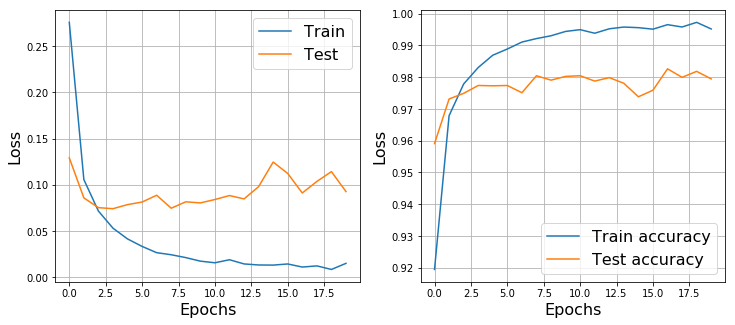

In [7]:
##### YOUR CODE HERE #####
# Non-normalized
network = nn.Sequential(nn.Linear(784, 200),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))

train_loss_no, test_loss_no, train_acc_no, test_acc_no = train_utils.train(network,
                                                               train_loader,
                                                               test_loader,
                                                               20,
                                                               0.001,
                                                               ravel_init=True,
                                                               cuda=True)

Epoch 0... (Train/Test) NLL: 0.260/0.100	Accuracy: 0.937/0.969
Epoch 1... (Train/Test) NLL: 0.081/0.078	Accuracy: 0.975/0.975
Epoch 2... (Train/Test) NLL: 0.052/0.068	Accuracy: 0.984/0.977
Epoch 3... (Train/Test) NLL: 0.038/0.066	Accuracy: 0.988/0.979
Epoch 4... (Train/Test) NLL: 0.028/0.066	Accuracy: 0.991/0.979
Epoch 5... (Train/Test) NLL: 0.022/0.069	Accuracy: 0.993/0.977
Epoch 6... (Train/Test) NLL: 0.018/0.080	Accuracy: 0.994/0.979
Epoch 7... (Train/Test) NLL: 0.019/0.066	Accuracy: 0.994/0.981
Epoch 8... (Train/Test) NLL: 0.015/0.069	Accuracy: 0.995/0.981
Epoch 9... (Train/Test) NLL: 0.014/0.076	Accuracy: 0.996/0.980
Epoch 10... (Train/Test) NLL: 0.011/0.073	Accuracy: 0.996/0.980
Epoch 11... (Train/Test) NLL: 0.013/0.079	Accuracy: 0.996/0.979
Epoch 12... (Train/Test) NLL: 0.009/0.078	Accuracy: 0.997/0.981
Epoch 13... (Train/Test) NLL: 0.010/0.077	Accuracy: 0.996/0.981
Epoch 14... (Train/Test) NLL: 0.009/0.076	Accuracy: 0.997/0.981
Epoch 15... (Train/Test) NLL: 0.008/0.081	Accuracy

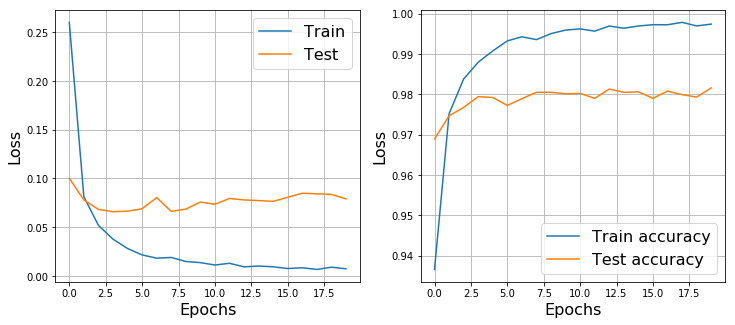

In [10]:
# Batch norm
network = nn.Sequential(nn.Linear(784, 200),
                      nn.BatchNorm1d(200),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.BatchNorm1d(200),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))

train_loss_bn, test_loss_bn, train_acc_bn, test_acc_bn = train_utils.train(network,
                                                               train_loader,
                                                               test_loader,
                                                               20,
                                                               0.001,
                                                               ravel_init=True,
                                                               cuda=True)

Epoch 0... (Train/Test) NLL: 0.233/0.111	Accuracy: 0.935/0.966
Epoch 1... (Train/Test) NLL: 0.093/0.086	Accuracy: 0.972/0.972
Epoch 2... (Train/Test) NLL: 0.064/0.097	Accuracy: 0.980/0.971
Epoch 3... (Train/Test) NLL: 0.050/0.077	Accuracy: 0.984/0.978
Epoch 4... (Train/Test) NLL: 0.040/0.079	Accuracy: 0.987/0.976
Epoch 5... (Train/Test) NLL: 0.033/0.082	Accuracy: 0.989/0.975
Epoch 6... (Train/Test) NLL: 0.028/0.069	Accuracy: 0.991/0.980
Epoch 7... (Train/Test) NLL: 0.025/0.068	Accuracy: 0.992/0.981
Epoch 8... (Train/Test) NLL: 0.019/0.077	Accuracy: 0.994/0.978
Epoch 9... (Train/Test) NLL: 0.021/0.077	Accuracy: 0.993/0.981
Epoch 10... (Train/Test) NLL: 0.016/0.093	Accuracy: 0.995/0.977
Epoch 11... (Train/Test) NLL: 0.015/0.076	Accuracy: 0.995/0.980
Epoch 12... (Train/Test) NLL: 0.014/0.082	Accuracy: 0.995/0.979
Epoch 13... (Train/Test) NLL: 0.014/0.082	Accuracy: 0.995/0.981
Epoch 14... (Train/Test) NLL: 0.010/0.082	Accuracy: 0.997/0.980
Epoch 15... (Train/Test) NLL: 0.013/0.093	Accuracy

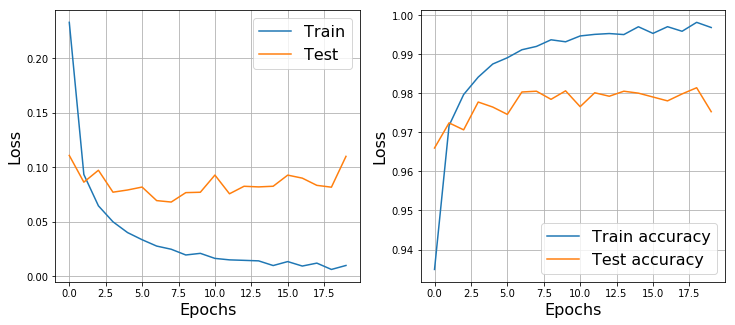

In [19]:
# Layer norm
network = nn.Sequential(nn.Linear(784, 200),
                      LayerNormalization(200),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      LayerNormalization(200),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.LogSoftmax(1))

train_loss_ln, test_loss_ln, train_acc_ln, test_acc_ln = train_utils.train(network,
                                                               train_loader,
                                                               test_loader,
                                                               20,
                                                               0.001,
                                                               ravel_init=True,
                                                               cuda=True)

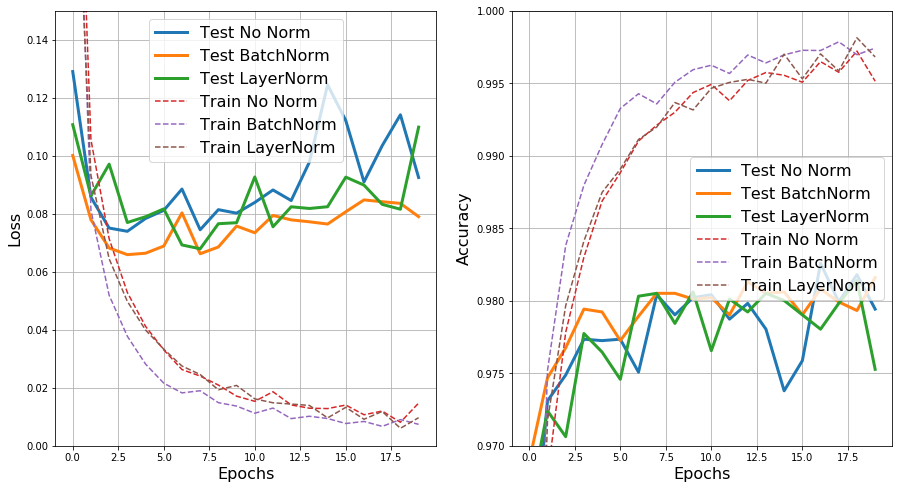

In [20]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(test_loss_no, label='Test No Norm', linewidth=3)
plt.plot(test_loss_bn, label='Test BatchNorm', linewidth=3)
plt.plot(test_loss_ln, label='Test LayerNorm', linewidth=3)
plt.plot(train_loss_no, '--', label='Train No Norm')
plt.plot(train_loss_bn, '--', label='Train BatchNorm')
plt.plot(train_loss_ln, '--', label='Train LayerNorm')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim(0.0, 0.15)
plt.legend(loc=0, fontsize=16)
plt.grid('on')

plt.subplot(1, 2, 2)
plt.plot(test_acc_no, label='Test No Norm', linewidth=3)
plt.plot(test_acc_bn, label='Test BatchNorm', linewidth=3)
plt.plot(test_acc_ln, label='Test LayerNorm', linewidth=3)
plt.plot(train_acc_no, '--', label='Train No Norm')
plt.plot(train_acc_bn, '--', label='Train BatchNorm')
plt.plot(train_acc_ln, '--', label='Train LayerNorm')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0.97, 1.0)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

<i> 3.3 Сделайте выводы по третьей части </i>

Для сети с рассматриваемой архитектурой заметного улучшения нет.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: